In [20]:
from bb_astromodels.xray.absorption import integrate_absori
from scipy.interpolate import interp1d
import numpy as np

x=np.logspace(0,2,100)
n0=10**-5
z=2.23
temp=10**4
xi=30
gamma=2
abundance=0
fe_abundance=0

# get the "true absori"
int_abs = integrate_absori()
astro_intabso = int_abs.evaluate(x=x, n0=n0, redshift=z, temp=temp, xi=xi,
                           gamma=gamma, abundance=abundance, fe_abundance=fe_abundance)

# put some mock gaussian noise on it for testing
observed = np.random.normal(astro_intabso, scale=0.1)

# interpolate all the sigma matrices for all input energies and redshift combinations
# a bit messy at the moment
def interpolate_sigma(x):
    res = np.zeros((100, 50*10, 26, 10))
    mask = x<int_abs._base_energy[-1]
    res[mask]=sigma_interp(x[mask])
    
    res[~mask] = np.expand_dims(int_abs._sigma[720], axis=0)
    res[~mask] *= np.expand_dims(np.power((x[~mask]/int_abs._base_energy[-1]),-3.0), axis=(1,2))
    return res
sigma_interp = interp1d(int_abs._base_energy, int_abs._sigma,axis=0)
energy_z = np.zeros((100, 500))
for i in range(energy_z.shape[1]):
    energy_z[:,i]=(((i+1)*0.02-0.01)+1)*x
sigma_inter = interpolate_sigma(energy_z*1000)
sigma_inter=np.swapaxes(sigma_inter, 0, 1)
sigma_inter=np.swapaxes(sigma_inter, 2,3)

ab = int_abs._load_abundance()
ab[2:-1]*= 10**abundance
ab[-1] *= 10**fe_abundance


# stan data dict - free T and n0
data_dict = {"sigma": int_abs._sigma.T,"ion": int_abs._ion, "atomicnumber": int_abs._atomicnumber, "e_edges": x, 
             "spec": int_abs._calc_ion_spec(2), "z": z, "xi": xi, "sigma_interp": sigma_inter, 
             "abundance":ab, "observed": observed}

In [21]:
import cmdstanpy
cmdstanpy.set_cmdstan_path("/home/bjorn/general_sw/cmdstan-2.26.0-rc1")

model = cmdstanpy.CmdStanModel(
    stan_file="test.stan"
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/bjorn/Documents/jupyter/pyspi_notebooks/test


In [31]:
f = model.sample(data=data_dict, output_dir="./", chains=4, parallel_chains=4, 
                 iter_warmup=500, iter_sampling=500, show_progress=True)

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|          | 0/1000 [00:00<?, ?it/s]


Chain 2 - warmup:   0%|          | 0/1000 [00:00<?, ?it/s]


Chain 4 - warmup:  10%|█         | 100/1000 [04:14<38:11,  2.55s/it]

Chain 2 - warmup:  10%|█         | 100/1000 [05:30<49:37,  3.31s/it]


Chain 2 - warmup:  20%|██        | 200/1000 [07:49<29:02,  2.18s/it]

Chain 3 - warmup:  20%|██        | 200/1000 [08:05<30:19,  2.27s/it]


Chain 2 - warmup:  30%|███       | 300/1000 [09:40<19:43,  1.69s/it]


Chain 4 - warmup:  40%|████      | 400/1000 [09:43<12:25,  1.24s/it]

Chain 2 - warmup:  40%|████      | 400/1000 [11:12<13:51,  1.39s/it]

Chain 3 - warmup:  40%|████      | 400/1000 [11:31<14:23,  1.44s/it]


Chain 4 - warmup:  50%|████

In [32]:
import arviz as av
av_res = av.from_cmdstanpy(f)

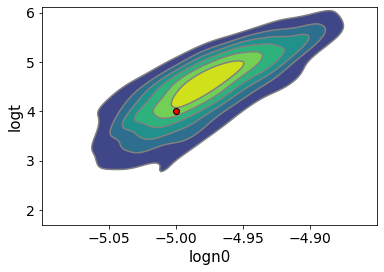

In [34]:
av.plot_pair(av_res, var_names=["logn0", "logt"], kind="kde", 
             reference_values={"logn0": -5, "logt": 4}, reference_values_kwargs={"color": "red"})

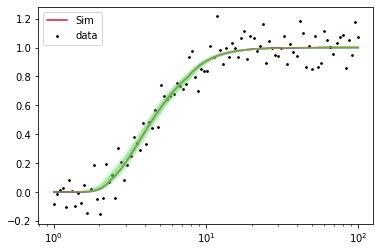

In [45]:
import matplotlib.pyplot as plt

plt.scatter(x, observed, s=3, color="black", label="data")
plt.plot(x, astro_intabso, color="crimson", label="Sim")
plt.plot(x, av_res.posterior.abs.data[0].T, color="lightgreen", alpha=0.01);
plt.legend()
plt.xscale("log")